In [1]:
#|default_exp sgd

# Accelerated SGD

In [2]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [3]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [4]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

### SGD

In [8]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1 # track batch num
    # step and zero grad an optmizer baseline methods
    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [9]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.477,0,eval
0.846,0.424,1,train
0.849,0.418,1,eval
0.865,0.372,2,train
0.847,0.415,2,eval


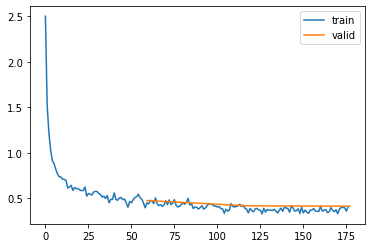

In [10]:
learn.fit(3)

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr*wd*weight
```

...vs...

``` python
weight.grad += wd*weight
```

### Momentum

In [11]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

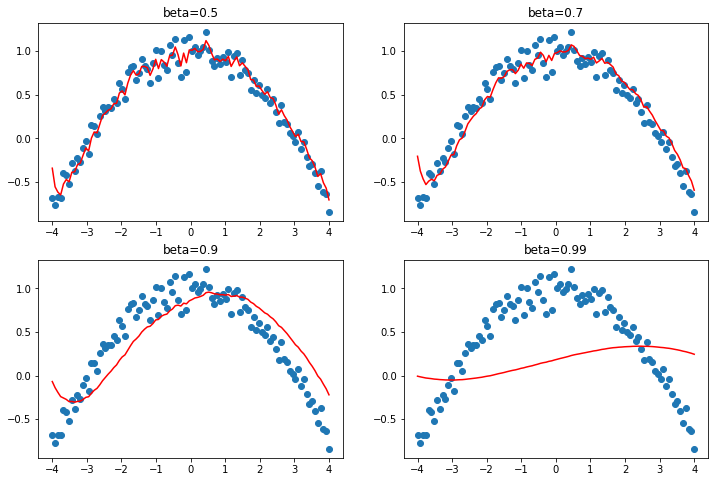

In [12]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [13]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [14]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.787,0.597,0,train
0.846,0.417,0,eval
0.869,0.360,1,train
0.862,0.370,1,eval
0.887,0.312,2,train
0.871,0.356,2,eval


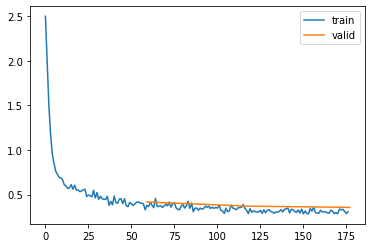

In [15]:
learn.fit(3)

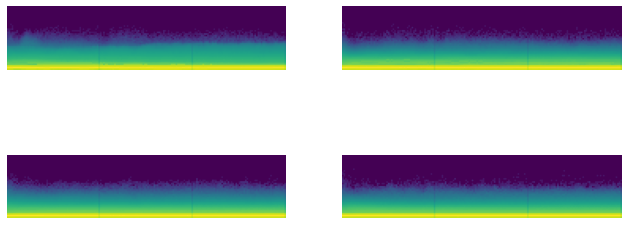

In [16]:
astats.color_dim()

### RMSProp

In [17]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.766,0.664,0,train
0.821,0.482,0,eval
0.848,0.416,1,train
0.845,0.425,1,eval
0.866,0.367,2,train
0.851,0.402,2,eval


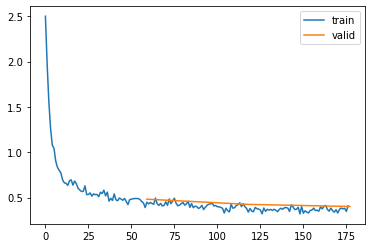

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

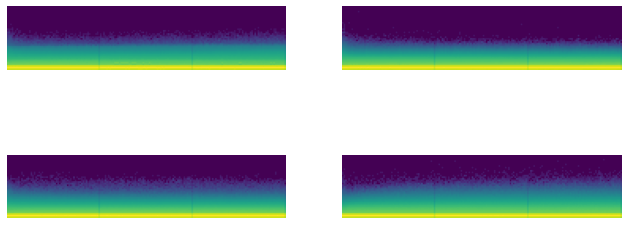

In [19]:
astats.color_dim()

### Adam

In [20]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.583,0,train
0.840,0.428,0,eval
0.870,0.359,1,train
0.857,0.381,1,eval
0.886,0.312,2,train
0.873,0.345,2,eval


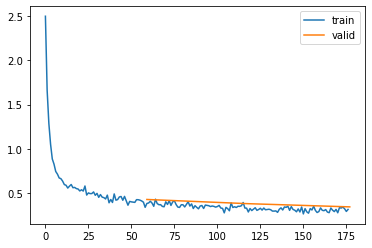

In [21]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [26]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [36]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [37]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [38]:
# a good way to test and look into learner is to use the single batch callback
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [39]:
learn.opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [32]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

In [40]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [34]:
# grab all params (only one group here)
# pytorch uses param tensors as keys and when you use then as keys
# you get its state
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [35]:
st

{'momentum_buffer': None}

In [41]:
# parameter is a tensor, stored as keys
param

Parameter containing:
tensor([[[[-0.19,  0.16, -0.14],
          [ 0.20,  0.13, -0.19],
          [-0.07, -0.22, -0.26]]],


        [[[ 0.08,  0.33, -0.02],
          [ 0.32,  0.08,  0.28],
          [-0.07,  0.18,  0.14]]],


        [[[-0.30,  0.10,  0.04],
          [-0.19, -0.08,  0.00],
          [-0.12,  0.32, -0.32]]],


        [[[-0.31, -0.05,  0.23],
          [ 0.02, -0.15, -0.33],
          [ 0.07,  0.19,  0.27]]],


        [[[-0.11,  0.33,  0.00],
          [-0.08, -0.30, -0.33],
          [-0.13, -0.14, -0.32]]],


        [[[-0.07,  0.05, -0.28],
          [ 0.00, -0.08,  0.25],
          [-0.07, -0.27, -0.14]]],


        [[[ 0.16,  0.27, -0.19],
          [ 0.10, -0.04, -0.06],
          [-0.26, -0.25,  0.01]]],


        [[[-0.10,  0.20, -0.06],
          [-0.04, -0.05,  0.29],
          [ 0.07,  0.28,  0.23]]]], device='cuda:0', requires_grad=True)

In [42]:
param.shape

torch.Size([8, 1, 3, 3])

In [43]:
st

{'momentum_buffer': None}

In [44]:
# only one param group here, simple SGD
len(opt.param_groups)

1

In [45]:
pg = opt.param_groups[0]

In [46]:
# pg

In [47]:
# all the params in group (params) 
# and all the hyper params for each group lr, momemtum, weight decay...
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

In [59]:
# in pytorch a scheduler needs it's optmizer
# why? he needs to lear what optmizer it needs to change its Lr
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [60]:
# gets this from the optmizer
sched.base_lrs

[0.006]

In [61]:
# you can also the th emost recent lr
sched.get_last_lr()

[0.001236644243122581]

In [62]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step() # this casues the scheduler to adjust its lr
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

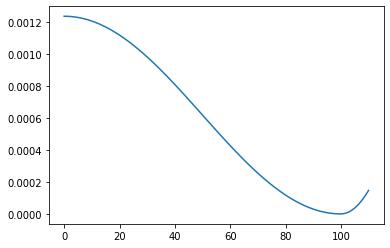

In [63]:
sched_lrs(sched, 110) # over 100 the cosine curve restarts

### Scheduler callbacks

In [64]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [65]:
#|export
class BatchSchedCB(BaseSchedCB):
    # if updates are required evr batch
    def after_batch(self, learn): self._step(learn)

In [66]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [67]:
#|export
class RecorderCB(Callback):
    # to see what our Learner is doing
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            # here the stats are recorded after batch
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [68]:
def _lr(cb): return cb.pg['lr'] # function grabs what we needs for recorder cb

In [69]:
dls.train.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [70]:
len(dls.train) # number of batches per epoch

59

In [71]:
dls.train.batch_size

1024

In [72]:
1024 * 59

60416

In [74]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.806,0.525,0,train
0.847,0.416,0,eval
0.878,0.331,1,train
0.878,0.331,1,eval
0.898,0.282,2,train
0.881,0.318,2,eval


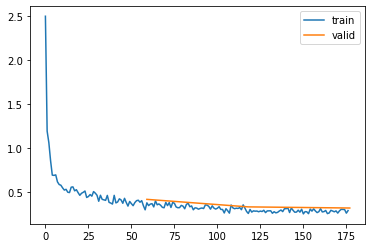

In [75]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

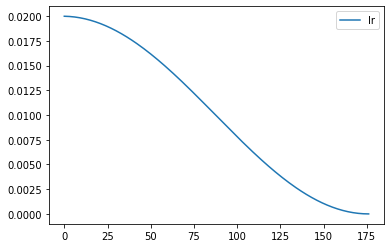

In [76]:
rec.plot()

In [77]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.806,0.524,0,train
0.858,0.380,0,eval
0.879,0.328,1,train
0.874,0.336,1,eval
0.899,0.274,2,train
0.883,0.310,2,eval


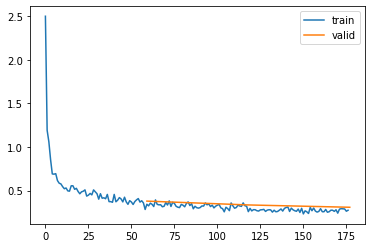

In [58]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3) # 3 epochs
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

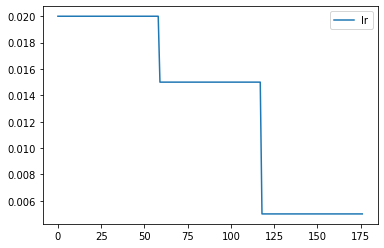

In [59]:
rec.plot()

In [84]:
# Simple Step Decay Scheduler
class StepLR:
    def __init__(self, optimizer, step_size, gamma=0.1):
        """
        Args:
            optimizer: The optimizer to adjust the learning rate for.
            step_size: Number of epochs between learning rate updates.
            gamma: Factor by which to decrease the learning rate.
        """
        self.optimizer = optimizer
        self.step_size = step_size
        self.gamma = gamma
        self.last_epoch = 0  # Tracks the current epoch

    def step(self, epoch=None):
        """
        Update the learning rate based on the current epoch.
        
        Args:
            epoch: The current epoch. If None, will use internal tracking.
        """
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch

        # Update learning rate if we are at the step_size interval
        if epoch % self.step_size == 0:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] *= self.gamma
                print(f"Learning rate updated to {param_group['lr']} at epoch {epoch}")

<module 'torch.optim' from '/usr/local/lib/python3.9/dist-packages/torch/optim/__init__.py'>

In [87]:
sched = StepLR(optim.AdamW, step_size=5, gamma=0.5)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

TypeError: 'StepLR' object is not callable

In [84]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

NameError: name 'optimizer' is not defined

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [56]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.768,0.659,0,train
0.842,0.458,0,eval
0.857,0.389,1,train
0.854,0.419,1,eval
0.885,0.307,2,train
0.883,0.329,2,eval
0.907,0.250,3,train
0.899,0.279,3,eval
0.922,0.212,4,train
0.903,0.267,4,eval


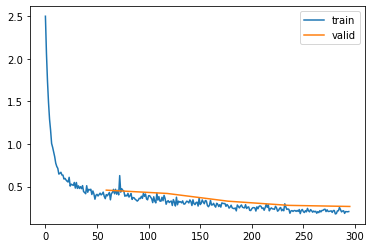

In [57]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

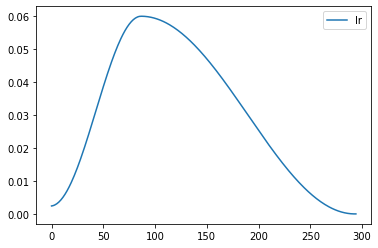

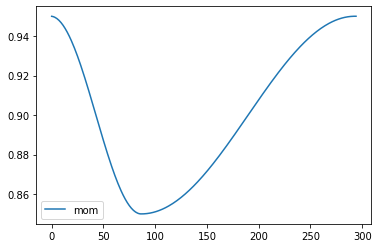

In [59]:
rec.plot()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()